# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 1000, #lambda-nets to load
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 200,
        'early_stopping_lambda': False,  #if early stopping is used, multi_epoch_analysis is deactivated
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000, #lambda-net training size
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 1000, #interpretation-net dataset size
                
        'interpretation_net_output_monomials': 3, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': None, #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 0,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': False,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense[512, 1024]convNonelstmNoneoutput_6_drop0.25e500b512_customlnets_1000_30-200e64b_adam_mae_train_1000_var_1_d_5_sparsity_6_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0_diffX_1-FixSeed_42
lnets_1000_30-200e64b_adam_mae_train_1000_var_1_d_5_sparsity_6_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0_diffX_1-FixSeed_42


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + path_identifier_lambda_net_data + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 out of   1 | elapsed:    1.0s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
521,1373158606,0.346,-0.838,0.903,0.677,0.610,0.646,0.227,-0.260,2.463,-10.680,18.816,-8.397,0.227,-0.260,2.463,-10.680,18.816,-8.397,-0.009,-0.227,0.257,0.080,0.604,0.563,0.526,-0.297,0.066,1.179,0.381,-0.088,-0.019,0.403,0.617,0.376,0.384,0.773,0.407,0.716,0.710,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.003,-0.082,-0.227,-0.240,-0.426,0.000,-0.070,-0.825,-0.005,0.000,0.000,-0.326,-0.385,-0.005,-0.309,-0.439,0.147,-0.359,-0.552,-0.048,-0.023,0.000,0.000,0.000,-0.053,0.000,0.000,0.000,-0.254,-0.359,-0.250,-0.221,0.693,0.794,0.692,-0.408,-0.257,1.033,-0.109,-0.352,-0.364,0.445,0.872,-0.196,1.161,0.750,0.381,0.698,1.098,-0.310,-0.045,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.162
737,1373158606,0.199,0.457,-0.369,-0.214,-0.526,-0.806,0.203,0.549,-1.751,4.969,-7.839,2.679,0.203,0.549,-1.751,4.969,-7.839,2.679,-0.009,-0.227,0.518,0.455,0.221,0.156,0.527,-0.297,0.437,0.656,0.629,-0.088,-0.019,0.543,0.152,0.642,0.009,0.275,0.310,0.290,0.042,0.407,0.451,-0.042,-0.404,-0.090,0.412,-0.291,-0.209,-0.233,0.000,0.000,-0.274,-0.318,0.072,0.073,-0.343,0.000,-0.342,-0.486,-0.277,0.000,0.000,-0.325,0.073,-0.191,0.076,0.069,0.071,0.070,0.082,-0.346,-0.387,0.000,0.000,0.000,-0.336,0.000,0.000,0.000,-0.254,-0.359,-0.846,-1.022,0.235,0.277,-0.809,-0.408,-1.123,-0.752,-0.625,-0.352,-0.364,-0.761,0.212,-0.656,0.494,0.112,0.265,0.149,0.147,-1.257,-1.138,-0.261,-0.383,-0.059,-1.256,0.144,-0.258,-0.315,0.072
740,1373158606,0.749,0.661,-0.551,-0.201,-0.181,0.956,0.745,0.778,-1.764,3.232,-2.787,0.914,0.745,0.778,-1.764,3.232,-2.787,0.914,-0.009,-0.227,0.282,0.082,0.280,0.217,0.254,-0.297,0.067,0.279,0.390,-0.088,-0.019,0.290,0.213,0.375,0.075,0.328,0.368,0.345,0.113,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.033,-0.083,0.196,0.195,-0.007,0.000,-0.069,0.203,-0.066,0.000,0.000,-0.017,0.201,-0.064,0.191,0.210,0.192,0.203,0.224,-0.047,-0.022,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.304,-0.226,0.346,0.387,-0.152,-0.408,-0.258,0.092,-0.154,-0.352,-0.364,-0.161,0.324,-0.234,0.608,0.223,0.372,0.259,0.261,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.174
660,1373158606,0.148,-0.214,-0.943,0.167,-0.977,0.575,0.146,-0.172,-1.207,0.819,-1.672,0.841,0.146,-0.172,-1.207,0.819,-1.672,0.841,-0.009,-0.227,0.498,0.384,0.086,0.054,0.457,-0.297,0.357,0.586,0.630,-0.088,-0.019,0.507,0.064,0.610,0.008,0.242,0.168,0.193,0.034,0.311,0.336,-0.042,-0.404,-0.090,0.323,-0.291,-0.209,-0.233,0.000,0.000,-0.105,-0.209,0.091,-0.066,-0.214,0.000,-0.223,-0.232,-0.051,0.000,0.000,-0.161,-0.075,-0.009,-0.026,0.014,0.100,0.058,-0.045,-0.246,-0.297,0.000,0.000,0.000,-0.228,0.000,0.000,0.000,-0.254,-0.359,-0.536,-0.622,0.103,0.149,-0.437,-0.408,-0.679,-0.320,-0.367,-0.352,-0.364,-0.412,0.092,-0.445,0.393,-0.054,0.127,0.001,0.047,-0.779,-0.634,-0.261,-0.383,-0.059,-0.787,0.144,-0.258,-0.315,0.122
411,1373158606,-0.210,-0.921,-0.049,0.086,-0.545,0.928,-0.204,-1.105,1.432,-4.403,5.120,-1.583,-0.204,-1.105,1.432,-4.403,5.120,-1.583,-0.009,-0.227,0.364,0.258,0.383,0.356,0.322,-0.297,0.225,0.396,0.489,-0.088,-0.019,0.368,0.389,0.473,0.008,0.458,0.418,0.436,0.034,0.173,0.119,-0.042,-0.404,-0.090,0.184,-0.291,-0.209,-0.233,0.000,0.

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,1373158606.000,0.004,-0.027,-0.039,0.029,-0.001,-0.001,0.005,-0.026,-0.041,-0.085,0.284,-0.177,0.005,-0.026,-0.041,-0.085,0.284,-0.177,-0.009,-0.227,0.296,0.204,0.288,0.231,0.292,-0.297,0.175,0.464,0.471,-0.088,-0.019,0.333,0.235,0.406,0.083,0.421,0.369,0.392,0.160,0.123,0.074,-0.042,-0.404,-0.090,0.135,-0.291,-0.209,-0.233,0.000,0.000,-0.011,-0.027,-0.006,-0.015,-0.048,0.000,-0.029,-0.075,-0.015,0.000,0.000,-0.037,-0.028,0.009,0.010,-0.061,0.029,-0.010,-0.023,-0.022,-0.007,0.000,0.000,0.000,-0.023,0.000,0.000,0.000,-0.254,-0.359,-0.381,-0.432,0.363,0.427,-0.228,-0.408,-0.477,0.016,-0.154,-0.352,-0.364,-0.216,0.376,-0.278,0.620,0.151,0.352,0.208,0.328,-0.528,-0.268,-0.261,-0.383,-0.059,-0.555,0.144,-0.258,-0.315,0.007
std,0.000,0.575,0.588,0.580,0.569,0.582,0.579,0.541,0.675,1.713,5.458,8.060,3.564,0.541,0.675,1.713,5.458,8.060,3.564,0.000,0.000,0.137,0.145,0.155,0.159,0.172,0.000,0.148,0.277,0.162,0.000,0.000,0.160,0.169,0.133,0.152,0.227,0.150,0.172,0.214,0.150,0.197,0.000,0.000,0.000,0.149,0.000,0.000,0.000,0.000,0.000,0.145,0.160,0.172,0.183,0.190,0.000,0.165,0.299,0.169,0.000,0.000,0.177,0.202,0.130,0.163,0.246,0.129,0.185,0.225,0.165,0.194,0.000,0.000,0.000,0.162,0.000,0.000,0.000,0.000,0.000,0.168,0.233,0.213,0.248,0.298,0.000,0.260,0.396,0.284,0.000,0.000,0.274,0.266,0.164,0.302,0.411,0.158,0.301,0.340,0.294,0.335,0.000,0.000,0.000,0.285,0.000,0.000,0.000,0.141
min,1373158606.000,-1.000,-0.998,-0.999,-1.000,-1.000,-1.000,-1.005,-1.705,-5.542,-21.522,-37.334,-15.292,-1.005,-1.705,-5.542,-21.522,-37.334,-15.292,-0.009,-0.227,-0.106,-0.205,-0.137,-0.221,-0.150,-0.297,-0.234,-0.073,0.147,-0.088,-0.019,-0.089,-0.241,0.069,-0.291,-0.023,-0.011,-0.017,-0.337,-0.274,-0.401,-0.042,-0.404,-0.090,-0.262,-0.291,-0.209,-0.233,0.000,0.000,-0.362,-0.448,-0.502,-0.548,-0.642,0.000,-0.450,-0.905,-0.641,0.000,0.000,-0.564,-0.550,-0.362,-0.479,-0.762,-0.358,-0.617,-0.590,-0.485,-0.618,0.000,0.000,0.000,-0.462,0.000,0.000,0.000,-0.254,-0.359,-1.058,-1.258,0.032,0.114,-1.044,-0.408,-1.345,-0.954,-0.818,-0.352,-0.364,-0.979,0.045,-0.858,0.360,-1.412,-0.439,-1.122,-0.001,-1.895,-1.837,-0.261,-0.383,-0.059,-1.713,0.144,-0.258,-0.315,-0.448
25%,1373158606.000,-0.497,-0.527,-0.550,-0.456,-0.516,-0.490,

## Generate Datasets for Interpretation-Net training

In [14]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [15]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(810, 110)

In [16]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(90, 110)

In [17]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 110)

In [18]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
718,1373158606,0.657,0.567,-0.446,0.882,-0.751,0.750,0.599,0.741,-0.001,0.002,-0.002,0.001,0.599,0.741,-0.001,0.002,-0.002,0.001,-0.009,-0.227,0.119,0.083,0.333,0.270,0.106,-0.297,0.067,0.354,0.337,-0.088,-0.019,0.206,0.267,0.323,0.127,0.385,0.418,0.399,0.178,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.120,-0.084,0.158,0.157,-0.106,0.000,-0.070,0.145,-0.001,0.000,0.000,-0.006,0.161,-0.001,0.154,0.168,0.156,0.164,0.175,-0.048,-0.023,0.000,0.000,0.000,-0.053,0.000,0.000,0.000,-0.254,-0.359,-0.169,-0.225,0.350,0.385,-0.018,-0.408,-0.257,0.099,-0.071,-0.352,-0.364,-0.001,0.320,-0.151,0.579,0.230,0.384,0.268,0.238,-0.309,-0.044,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,0.143
457,1373158606,-0.608,-0.718,0.245,0.563,0.157,-0.706,-0.608,-0.709,-0.057,2.364,-3.371,1.420,-0.608,-0.709,-0.057,2.364,-3.371,1.420,-0.009,-0.227,0.294,0.187,0.267,0.212,0.246,-0.297,0.154,0.300,0.417,-0.088,-0.019,0.294,0.214,0.403,0.008,0.326,0.360,0.339,0.034,0.101,0.015,-0.042,-0.404,-0.090,0.113,-0.291,-0.209,-0.233,0.000,0.000,0.141,0.143,-0.085,-0.079,0.149,0.000,0.143,0.173,0.145,0.000,0.000,0.147,-0.081,0.142,-0.023,-0.087,-0.049,-0.077,-0.039,0.143,0.177,0.000,0.000,0.000,0.142,0.000,0.000,0.000,-0.254,-0.359,-0.353,-0.363,0.285,0.335,-0.200,-0.408,-0.395,-0.086,-0.209,-0.352,-0.364,-0.212,0.272,-0.287,0.393,0.160,0.310,0.197,0.049,-0.452,-0.221,-0.261,-0.383,-0.059,-0.474,0.144,-0.258,-0.315,-0.134
847,1373158606,0.675,-0.520,-0.610,0.010,0.537,-0.876,0.671,-0.378,-1.710,3.245,-3.483,0.895,0.671,-0.378,-1.710,3.245,-3.483,0.895,-0.009,-0.227,0.464,0.355,0.059,-0.008,0.432,-0.297,0.340,0.556,0.623,-0.088,-0.019,0.466,-0.017,0.600,-0.152,0.106,0.154,0.128,-0.138,0.330,0.368,-0.042,-0.404,-0.090,0.330,-0.291,-0.209,-0.233,0.000,0.000,-0.058,-0.203,0.180,0.186,-0.197,0.000,-0.225,-0.407,-0.001,0.000,0.000,-0.146,0.191,-0.001,0.191,0.180,0.173,0.176,0.225,-0.279,-0.325,0.000,0.000,0.000,-0.262,0.000,0.000,0.000,-0.254,-0.359,-0.490,-0.680,0.298,0.383,-0.457,-0.408,-0.796,-0.545,-0.366,-0.352,-0.364,-0.385,0.324,-0.443,0.703,0.147,0.279,0.174,0.336,-1.009,-0.903,-0.261,-0.383,-0.059,-0.993,0.144,-0.258,-0.315,0.172
921,1373158606,0.278,-0.837,-0.130,-0.415,0.091,-0.733,0.272,-0.662,-1.554,3.941,-5.450,1.739,0.272,-0.662,-1.554,3.941,-5.450,1.739,-0.009,-0.227,0.545,0.478,0.065,0.083,0.533,-0.297,0.471,0.655,0.688,-0.088,-0.019,0.550,0.082,0.661,0.008,0.287,0.141,0.184,0.034,0.446,0.513,-0.042,-0.404,-0.090,0.450,-0.291,-0.209,-0.233,0.000,0.000,-0.000,-0.302,0.140,-0.093,-0.291,0.000,-0.334,-0.290,-0.023,0.000,0.000,-0.155,-0.091,-0.004,-0.026,-0.000,0.181,0.088,-0.046,-0.370,-0.440,0.000,0.000,0.000,-0.348,0.000,0.000,0.000,-0.254,-0.359,-0.555,-0.869,0.126,0.181,-0.627,-0.408,-0.972,-0.459,-0.417,-0.352,-0.364,-0.452,0.115,-0.493,0.393,-0.100,0.166,0.011,0.048,-1.132,-1.057,-0.261,-0.383,-0.059,-1.122,0.144,-0.258,-0.315,0.222
938,1373158606,0.093,-0.817,0.513,0.165,-0.627,-0.624,0.072,-0.363,-2.379,7.849,-9.590,3.160,0.072,-0.363,-2.379,7.849,-9.590,3.160,-0.009,-0.227,0.404,0.428,0.142,0.077,0.370,-0.297,0.432,0.650,0.535,-0.088,-0.019,0.415,0.168,0.515,0.008,0.211,0.226,0.216,0.032,0.412,0.522,-0.042,-0.404,-0.090,0.418,-0.291,-0.209,-0.233,0.000,0.000

In [19]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
580,1373158606,-0.693,0.145,-0.446,0.843,0.166,0.186,-0.690,0.050,0.309,-1.426,3.018,-1.075,-0.690,0.050,0.309,-1.426,3.018,-1.075,-0.009,-0.227,0.106,-0.012,0.435,0.400,0.048,-0.297,-0.048,0.093,0.243,-0.088,-0.019,0.105,0.417,0.224,0.335,0.510,0.440,0.504,0.436,-0.106,-0.221,-0.042,-0.404,-0.090,-0.091,-0.291,-0.209,-0.233,0.000,0.000,0.153,0.159,-0.245,-0.285,0.162,0.000,0.161,0.180,0.149,0.000,0.000,0.156,-0.321,0.150,-0.293,-0.328,-0.148,-0.236,-0.361,0.164,0.220,0.000,0.000,0.000,0.162,0.000,0.000,0.000,-0.254,-0.359,-0.296,-0.374,0.656,0.811,-0.173,-0.408,-0.434,-0.046,-0.111,-0.352,-0.364,-0.157,0.785,-0.192,1.280,0.580,0.419,0.509,0.891,-0.542,-0.379,-0.261,-0.383,-0.059,-0.552,0.144,-0.258,-0.315,-0.149
451,1373158606,-0.760,-0.469,-0.965,-0.413,0.546,0.036,-0.717,-1.132,2.518,-8.499,9.029,-3.241,-0.717,-1.132,2.518,-8.499,9.029,-3.241,-0.009,-0.227,0.325,0.218,0.108,0.080,0.283,-0.297,0.185,0.361,0.451,-0.088,-0.019,0.330,0.078,0.435,0.008,0.692,0.136,0.540,0.033,0.132,0.078,-0.042,-0.404,-0.090,0.144,-0.291,-0.209,-0.233,0.000,0.000,0.157,0.158,-0.108,-0.081,0.165,0.000,0.158,0.186,0.162,0.000,0.000,0.163,-0.079,0.158,-0.023,-0.303,-0.136,-0.143,-0.039,0.157,0.179,0.000,0.000,0.000,0.157,0.000,0.000,0.000,-0.254,-0.359,-0.388,-0.396,0.137,0.187,-0.234,-0.408,-0.425,-0.120,-0.245,-0.352,-0.364,-0.247,0.121,-0.323,0.393,-0.629,0.119,-0.476,0.049,-0.474,-0.216,-0.261,-0.383,-0.059,-0.499,0.144,-0.258,-0.315,-0.148
530,1373158606,-0.779,-0.422,-0.380,-0.500,0.030,0.071,-0.734,-1.081,2.015,-3.090,-0.369,1.348,-0.734,-1.081,2.015,-3.090,-0.369,1.348,-0.009,-0.227,0.316,0.209,0.107,0.080,0.272,-0.297,0.176,0.343,0.441,-0.088,-0.019,0.319,0.078,0.426,0.008,0.951,0.310,0.264,0.033,0.123,0.060,-0.042,-0.404,-0.090,0.135,-0.291,-0.209,-0.233,0.000,0.000,0.162,0.163,-0.108,-0.081,0.171,0.000,0.163,0.194,0.167,0.000,0.000,0.169,-0.079,0.163,-0.023,-0.490,-0.002,-0.002,-0.039,0.163,0.188,0.000,0.000,0.000,0.162,0.000,0.000,0.000,-0.254,-0.359,-0.385,-0.394,0.136,0.187,-0.232,-0.408,-0.424,-0.118,-0.242,-0.352,-0.364,-0.244,0.122,-0.319,0.394,-0.958,0.238,0.088,0.049,-0.476,-0.222,-0.261,-0.383,-0.059,-0.500,0.144,-0.258,-0.315,-0.152
894,1373158606,0.030,0.981,0.223,-0.258,0.544,-0.659,0.027,1.110,-0.882,3.244,-4.054,1.454,0.027,1.110,-0.882,3.244,-4.054,1.454,-0.009,-0.227,0.289,0.280,0.403,0.339,0.303,-0.297,0.067,0.484,0.329,-0.088,-0.019,0.303,0.340,0.341,0.192,0.467,0.487,0.476,0.264,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.216,-0.225,0.005,0.006,-0.250,0.000,-0.069,-0.093,-0.181,0.000,0.000,-0.212,0.003,-0.217,0.010,-0.001,0.007,-0.000,-0.006,-0.047,-0.022,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.486,-0.701,0.367,0.395,-0.388,-0.408,-0.258,0.134,-0.176,-0.352,-0.364,-0.319,0.330,-0.318,0.557,0.251,0.407,0.290,0.234,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.017
590,1373158606,-0.579,0.618,-0.706,-0.315,0.729,-0.690,-0.409,-0.249,0.004,-0.009,0.009,-0.003,-0.409,-0.249,0.004,-0.009,0.009,-0.003,-0.009,-0.227,0.282,0.175,0.248,0.188,0.235,-0.297,0.142,0.290,0.405,-0.088,-0.019,0.283,0.185,0.390,0.008,0.295,0.332,0.311,0.033,0.089,0.012,-0.042,-0.404,-0.090,0.102,-0.291,-0.209,-0.233,0.000,0.

In [20]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
666,1373158606,-0.331,-0.211,0.060,-0.677,0.144,0.611,-0.328,-0.280,0.004,-0.010,0.010,-0.004,-0.328,-0.280,0.004,-0.010,0.010,-0.004,-0.009,-0.227,0.288,0.182,0.238,0.179,0.242,-0.297,0.149,0.297,0.411,-0.088,-0.019,0.289,0.175,0.397,0.008,0.285,0.323,0.302,0.093,0.097,0.026,-0.042,-0.404,-0.090,0.109,-0.291,-0.209,-0.233,0.000,0.000,0.086,0.087,-0.001,-0.000,0.088,0.000,0.087,0.094,0.087,0.000,0.000,0.087,-0.000,0.086,-0.023,-0.001,-0.001,-0.001,-0.000,0.087,0.100,0.000,0.000,0.000,0.087,0.000,0.000,0.000,-0.254,-0.359,-0.318,-0.319,0.218,0.248,-0.161,-0.408,-0.347,-0.048,-0.181,-0.352,-0.364,-0.176,0.182,-0.258,0.393,0.100,0.257,0.140,0.090,-0.395,-0.146,-0.261,-0.383,-0.059,-0.420,0.144,-0.258,-0.315,-0.085
129,1373158606,0.595,-0.700,-0.541,0.445,0.440,0.282,0.512,-0.410,0.000,-0.000,0.000,-0.000,0.512,-0.410,0.000,-0.000,0.000,-0.000,-0.009,-0.227,0.323,0.221,0.206,0.142,0.284,-0.297,0.189,0.364,0.447,-0.088,-0.019,0.329,0.136,0.431,-0.003,0.251,0.294,0.270,0.020,0.140,0.008,-0.042,-0.404,-0.090,0.151,-0.291,-0.209,-0.233,0.000,0.000,0.000,0.000,0.152,0.154,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.158,0.000,0.162,0.157,0.149,0.153,0.195,0.001,-0.023,0.000,0.000,0.000,0.001,0.000,0.000,0.000,-0.254,-0.359,-0.336,-0.334,0.270,0.318,-0.177,-0.408,-0.361,-0.060,-0.200,-0.352,-0.364,-0.194,0.255,-0.277,0.611,0.144,0.292,0.179,0.235,-0.407,-0.044,-0.261,-0.383,-0.059,-0.435,0.144,-0.258,-0.315,0.144
784,1373158606,-0.170,-0.156,0.570,-0.609,0.641,0.297,-0.173,-0.112,0.427,-0.489,0.728,0.193,-0.173,-0.112,0.427,-0.489,0.728,0.193,-0.009,-0.227,0.150,0.042,0.436,0.403,0.132,-0.297,0.007,0.504,0.294,-0.088,-0.019,0.173,0.423,0.265,0.318,0.480,0.468,0.481,0.412,-0.051,-0.095,-0.042,-0.404,-0.090,-0.038,-0.291,-0.209,-0.233,0.000,0.000,0.063,0.064,-0.299,-0.305,0.054,0.000,0.064,-0.093,0.057,0.000,0.000,0.057,-0.341,0.062,-0.283,-0.294,-0.170,-0.247,-0.354,0.065,0.097,0.000,0.000,0.000,0.065,0.000,0.000,0.000,-0.254,-0.359,-0.179,-0.193,0.697,0.803,-0.021,-0.408,-0.230,0.211,-0.035,-0.352,-0.364,-0.034,0.773,-0.113,1.261,0.521,0.478,0.493,0.852,-0.313,-0.169,-0.261,-0.383,-0.059,-0.327,0.144,-0.258,-0.315,-0.066
152,1373158606,0.248,-0.181,0.104,-0.128,-0.411,0.897,0.257,-0.631,4.254,-13.391,16.752,-6.839,0.257,-0.631,4.254,-13.391,16.752,-6.839,-0.009,-0.227,0.290,0.186,0.233,0.171,0.245,-0.297,0.154,1.026,0.412,-0.088,-0.019,0.291,0.167,0.397,0.030,0.280,0.320,0.298,0.069,0.037,0.008,-0.042,-0.404,-0.090,0.114,-0.291,-0.209,-0.233,0.000,0.000,-0.000,-0.000,0.084,0.084,-0.000,0.000,0.000,-0.691,-0.001,0.000,0.000,-0.000,0.085,-0.001,0.085,0.085,0.084,0.085,0.090,-0.043,-0.022,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.254,-0.359,-0.297,-0.289,0.240,0.275,-0.136,-0.408,-0.311,0.902,-0.165,-0.352,-0.364,-0.155,0.209,-0.241,0.479,0.120,0.276,0.159,0.129,-0.304,-0.045,-0.261,-0.383,-0.059,-0.371,0.144,-0.258,-0.315,0.083
920,1373158606,0.669,0.155,0.293,-0.083,0.057,-0.931,0.654,0.529,-2.452,7.871,-9.782,3.416,0.654,0.529,-2.452,7.871,-9.782,3.416,-0.009,-0.227,0.417,0.377,0.207,0.143,0.467,-0.297,0.360,0.143,0.527,-0.088,-0.019,0.464,0.134,0.483,-0.001,0.247,0.299,0.270,0.006,0.210,0.008,-0.042,-0.404,-0.090,0.343,-0.291,-0.209,-0.233,0.000,0.000,-0.275,-0.283,0

## Interpretation Network Training

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min finished


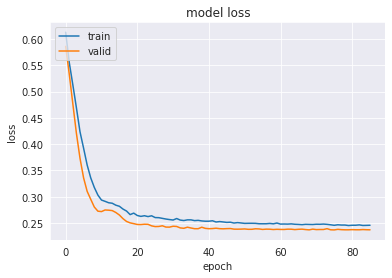

In [21]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [22]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [23]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               47104     
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 6150      
Total params: 578,566
Trainable params: 578,566
Non-trainable params: 0
_________________________________________________________________
None
{'name': 'sequential_1', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 91), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_2_input'}}, {'class_name': 'Dense', 'config': {'name': 'dense_2

In [24]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.494,0.579,20.497,0.076,0.000,0.233,0.301,0.825,0.000,inf,inf,0.286,-0.063,-0.061,0.672,0.800
inetPoly_VS_targetPoly_test,0.521,0.599,27.851,0.030,0.000,0.239,0.316,1.086,0.000,inf,inf,0.298,0.041,0.037,0.711,0.846
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.228,0.287,0.820,0.000,inf,NaN,0.273,-0.063,-0.062,0.672,0.787
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.233,0.299,1.075,0.000,inf,inf,0.282,0.041,0.036,0.711,0.832
inetPoly_VS_lstsqTarget_valid,2.279,4.119,51.776,0.059,0.000,0.228,0.287,0.820,0.000,inf,NaN,0.273,-0.063,-0.062,0.672,0.787
inetPoly_VS_lstsqTarget_test,2.426,4.560,79.073,0.055,0.000,0.233,0.299,1.075,0.000,inf,inf,0.283,0.041,0.036,0.711,0.832
inetPoly_VS_lstsqLambda_valid,2.279,4.119,51.776,0.059,0.000,0.228,0.287,0.820,0.000,inf,NaN,0.273,-0.063,-0.062,0.672,0.787
inetPoly_VS_lstsqLambda_test,2.426,4.560,79.073,0.055,0.000,0.233,0.299,1.075,0.000,inf,inf,0.283,0.041,0.036,0.711,0.832
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.003,0.004,0.015,0.999,0.012,0.049,0.004,-0.062,-0.062,0.787,0.787
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.003,0.004,0.016,1.000,0.011,0.042,0.004,0.036,0.036,0.832,0.832


In [25]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
inetPoly_VS_targetPoly_valid,0.162,0.330,0.303,0.243,0.106,0.079,0.327,0.294,0.296,0.032,0.687,0.351,0.127,0.057,0.229,0.098,0.194,0.013,0.097,0.236,0.142,0.234,0.053,0.450,0.273,0.128,0.053,0.187,0.063,0.287,0.645,0.325,0.109,0.635,0.154,0.221,0.702,0.063,0.183,0.055,0.132,0.057,0.081,0.086,0.026,0.402,0.220,0.479,0.061,0.225,0.090,0.084,0.236,0.284,0.045,0.342,0.215,0.198,0.377,0.195,0.624,0.102,0.411,0.184,0.169,0.417,0.290,0.116,0.258,0.190,0.394,0.236,0.309,0.545,0.480,0.448,0.342,0.304,0.376,0.257,0.308,0.100,0.061,0.091,0.207,0.163,0.172,0.105,0.087,0.175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inetPoly_VS_targetPoly_test,0.066,0.125,0.132,0.067,0.075,0.101,0.336,0.321,0.183,0.153,0.461,0.440,0.091,0.131,0.448,0.255,0.260,0.117,0.141,0.332,0.150,0.048,0.113,0.088,0.104,0.102,0.111,0.098,0.500,0.494,0.479,0.375,0.208,0.256,0.086,0.081,0.414,0.076,0.163,0.159,0.330,0.172,0.594,0.258,0.223,0.179,0.573,0.128,0.168,0.296,0.350,0.066,0.176,0.359,0.218,0.100,0.267,0.160,0.144,0.110,0.222,0.321,0.119,0.602,0.382,0.320,0.342,0.144,0.095,0.235,0.100,0.615,0.251,0.301,0.359,0.075,0.333,0.123,0.490,0.099,0.171,0.129,0.379,0.289,0.585,0.075,0.497,0.370,0.103,0.088,0.273,0.271,0.227,0.165,0.076,0.469,0.078,0.180,0.330,0.427
inetPoly_VS_predLambda_valid,0.162,0.333,0.302,0.244,0.077,0.073,0.331,0.301,0.295,0.034,0.662,0.353,0.125,0.062,0.227,0.055,0.198,0.013,0.095,0.237,0.143,0.234,0.044,0.450,0.280,0.128,0.053,0.183,0.065,0.285,0.639,0.325,0.111,0.634,0.150,0.172,0.702,0.063,0.182,0.057,0.129,0.057,0.082,0.085,0.013,0.391,0.219,0.452,0.063,0.228,0.072,0.098,0.226,0.283,0.024,0.342,0.215,0.193,0.379,0.194,0.622,0.084,0.411,0.180,0.124,0.417,0.279,0.115,0.258,0.190,0.383,0.236,0.311,0.524,0.476,0.444,0.329,0.293,0.374,0.247,0.279,0.058,0.062,0.098,0.208,0.164,0.188,0.103,0.037,0.205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inetPoly_VS_predLambda_test,0.073,0.107,0.133,0.061,0.072,0.085,0.343,0.320,0.182,0.158,0.460,0.440,0.086,0.129,0.441,0.220,0.263,0.114,0.061,0.334,0.154,0.048,0.113,0.092,0.065,0.102,0.108,0.094,0.497,0.475,0.475,0.376,0.208,0.262,0.085,0.080,0.411,0.044,0.162,0.162,0.324,0.165,0.594,0.258,0.243,0.180,0.553,0.127,0.166,0.275,0.349,0.014,0.176,0.359,0.202,0.066,0.266,0.131,0.144,0.106,0.220,0.324,0.119,0.605,0.383,0.324,0.324,0.144,0.095,0.163,0.097,0.612,0.252,0.261,0.359,0.074,0.335,0.116,0.488,0.099,0.164,0.129,0.378,0.290,0.564,0.068,0.497,0.369,0.102,0.088,0.272,0.271,0.227,0.127,0.080,0.467,0.077,0.179,0.331,0.426
inetPoly_VS_lstsqTarget_valid,0.162,0.333,0.304,0.244,0.077,0.073,0.331,0.300,0.295,0.033,0.660,0.352,0.125,0.062,0.228,0.055,0.198,0.013,0.095,0.237,0.142,0.234,0.044,0.450,0.280,0.128,0.053,0.185,0.065,0.286,0.641,0.326,0.111,0.635,0.148,0.169,0.702,0.063,0.183,0.056,0.129,0.057,0.082,0.084,0.013,0.390,0.220,0.454,0.062,0.228,0.072,0.098,0.226,0.283,0.024,0.342,0.215,0.194,0.379,0.195,0.622,0.084,0.411,0.180,0.124,0.417,0.279,0.115,0.258,0.190,0.381,0.236,0.311,0.525,0.477,0.444,0.330,0.291,0.374,0.246,0.281,0.058,0.062,0.098,0.208,0.164,0.188,0.104,0.037,0.205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inetPoly_VS_lstsqTarget_test,0.073,0.107,0.132,0.060,0.073,0.085,0.341,0.320,0.182,0.158,0.460,0.440,0.086,0.130,0.442,0.220,0.263,0.114,0.061,0.334,0.154,0.048,0.114,0.090,0.065,0.102,0.108,0.094,0.497,0.471,0.476,0.376,0.208,0.262,0.086,0.081,0.411,0.044,0.162,0.161,0.322,0.165,0.594,0.258,0.243,0.179,0.553,0.128,0.168,0.276,0.348,0.014,0.176,0.359,0.202,0.066,0.266,0.131,0.144,0.106,0.221,0.323,0.119,0.605,0.384,0.325,

In [26]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99
inetPoly_VS_targetPoly_valid,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inetPoly_VS_targetPoly_test,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
inetPoly_VS_predLambda_valid,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inetPoly_VS_predLambda_test,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
inetPoly_VS_lstsqTarget_valid,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
inetPoly_VS_lstsqTarget_test,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

0.0


0.249176874756813

In [28]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.8586132302283873


-0.631190188031381*a**1.0 + 4.25439156589623*a**2.0 - 13.3905241692803*a**3.0 + 16.7515280496446*a**4.0 - 6.83925969322647*a**5.0 + 0.256512723177845

In [29]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.181176695617519*a**1.0 + 0.10409436170396*a**2.0 - 0.127746941729367*a**3.0 - 0.411068480916165*a**4.0 + 0.896906613924313*a**5.0 + 0.248297815698268

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.0


0.497529394924641

In [31]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.5619189000941897


-0.592027895203465*a**1.0 + 2.22105637381898e-7*a**2.0 - 3.64122490104091e-7*a**3.0 + 3.84514413975801e-7*a**4.0 - 1.71782695568279e-7*a**5.0 + 0.802639732522118

In [32]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.63753386766868*a**1.0 - 0.867007465266445*a**2.0 + 0.482241298580118*a**3.0 + 0.148946226359824*a**4.0 + 0.683657553516544*a**5.0 + 0.876680913642076

In [33]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.0 (100 Samples)
Mean (only positive): nan (0 Samples)


In [34]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.046871455699664555 (100 Samples)
Mean (only positive): 0.9561499666609172 (93 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

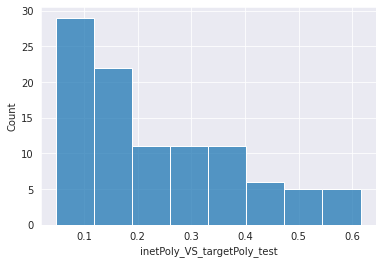

In [35]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

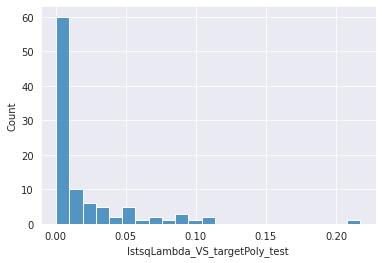

In [36]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

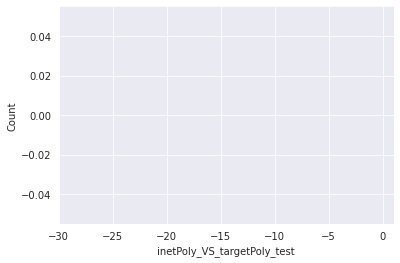

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

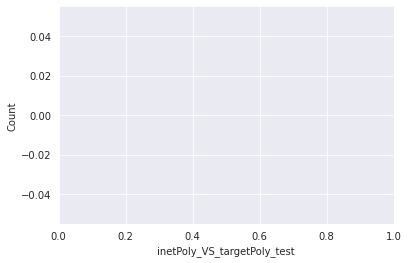

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

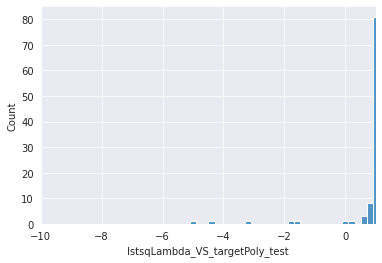

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

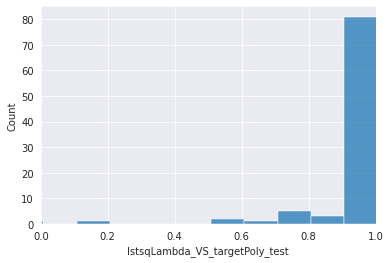

In [40]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

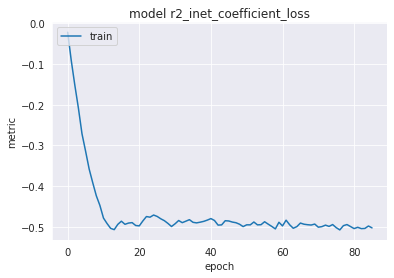

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


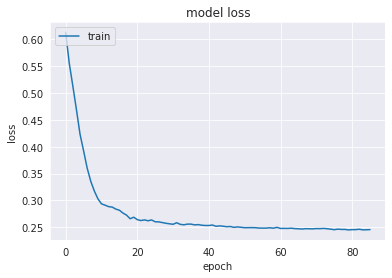

In [42]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [44]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [45]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [46]:
index = 6

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda, force_complete_poly_representation=True, round_digits=4)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet, round_digits=4)


Target Poly:


0.1817*a**1.0 - 0.939*a**2.0 - 0.9253*a**3.0 + 0.6452*a**4.0 - 0.2796*a**5.0 - 0.4269

LSTSQ Target Poly:


-0.614*a**1.0 + 0.5883*a**2.0 + 0.9994*a**3.0 - 6.3879*a**4.0 + 4.134*a**5.0 - 0.3373

LSTSQ Lambda Poly:


-0.614*a**1.0 + 0.5883*a**2.0 + 0.9994*a**3.0 - 6.3879*a**4.0 + 4.134*a**5.0 - 0.3373

I-Net Poly:


-0.812999993562698

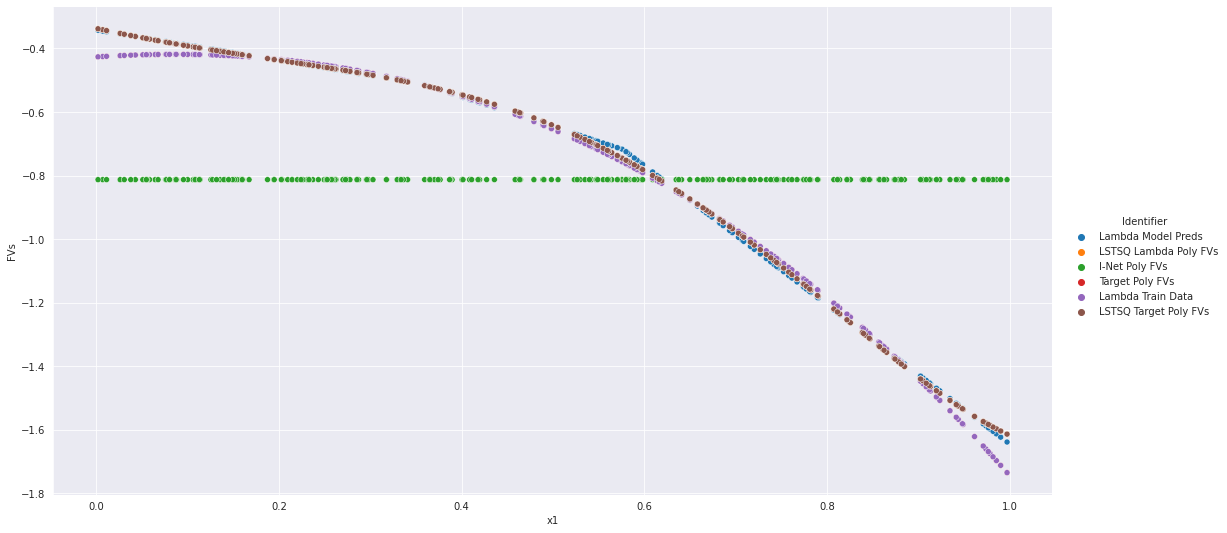

+---------------------------+-----------------------+-----------------------+--------+----------------------------------------------------+
|         Comparison        |          MAE          |        R2-Score       | Poly 1 |                       Poly 2                       |
+---------------------------+-----------------------+-----------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.0064961002659723955 |   0.9994484923276273  |   -    |  -0.614*a**1.0 + 0.5883*a**2.0 + 0.9994*a**3.0 -   |
|            vs.            |                       |                       |        |       6.3879*a**4.0 + 4.134*a**5.0 - 0.3373        |
|  LSTSQ Lambda Preds Poly  |                       |                       |        |                                                    |
|                           |                       |                       |        |                                                    |
|       Lambda Preds

In [47]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

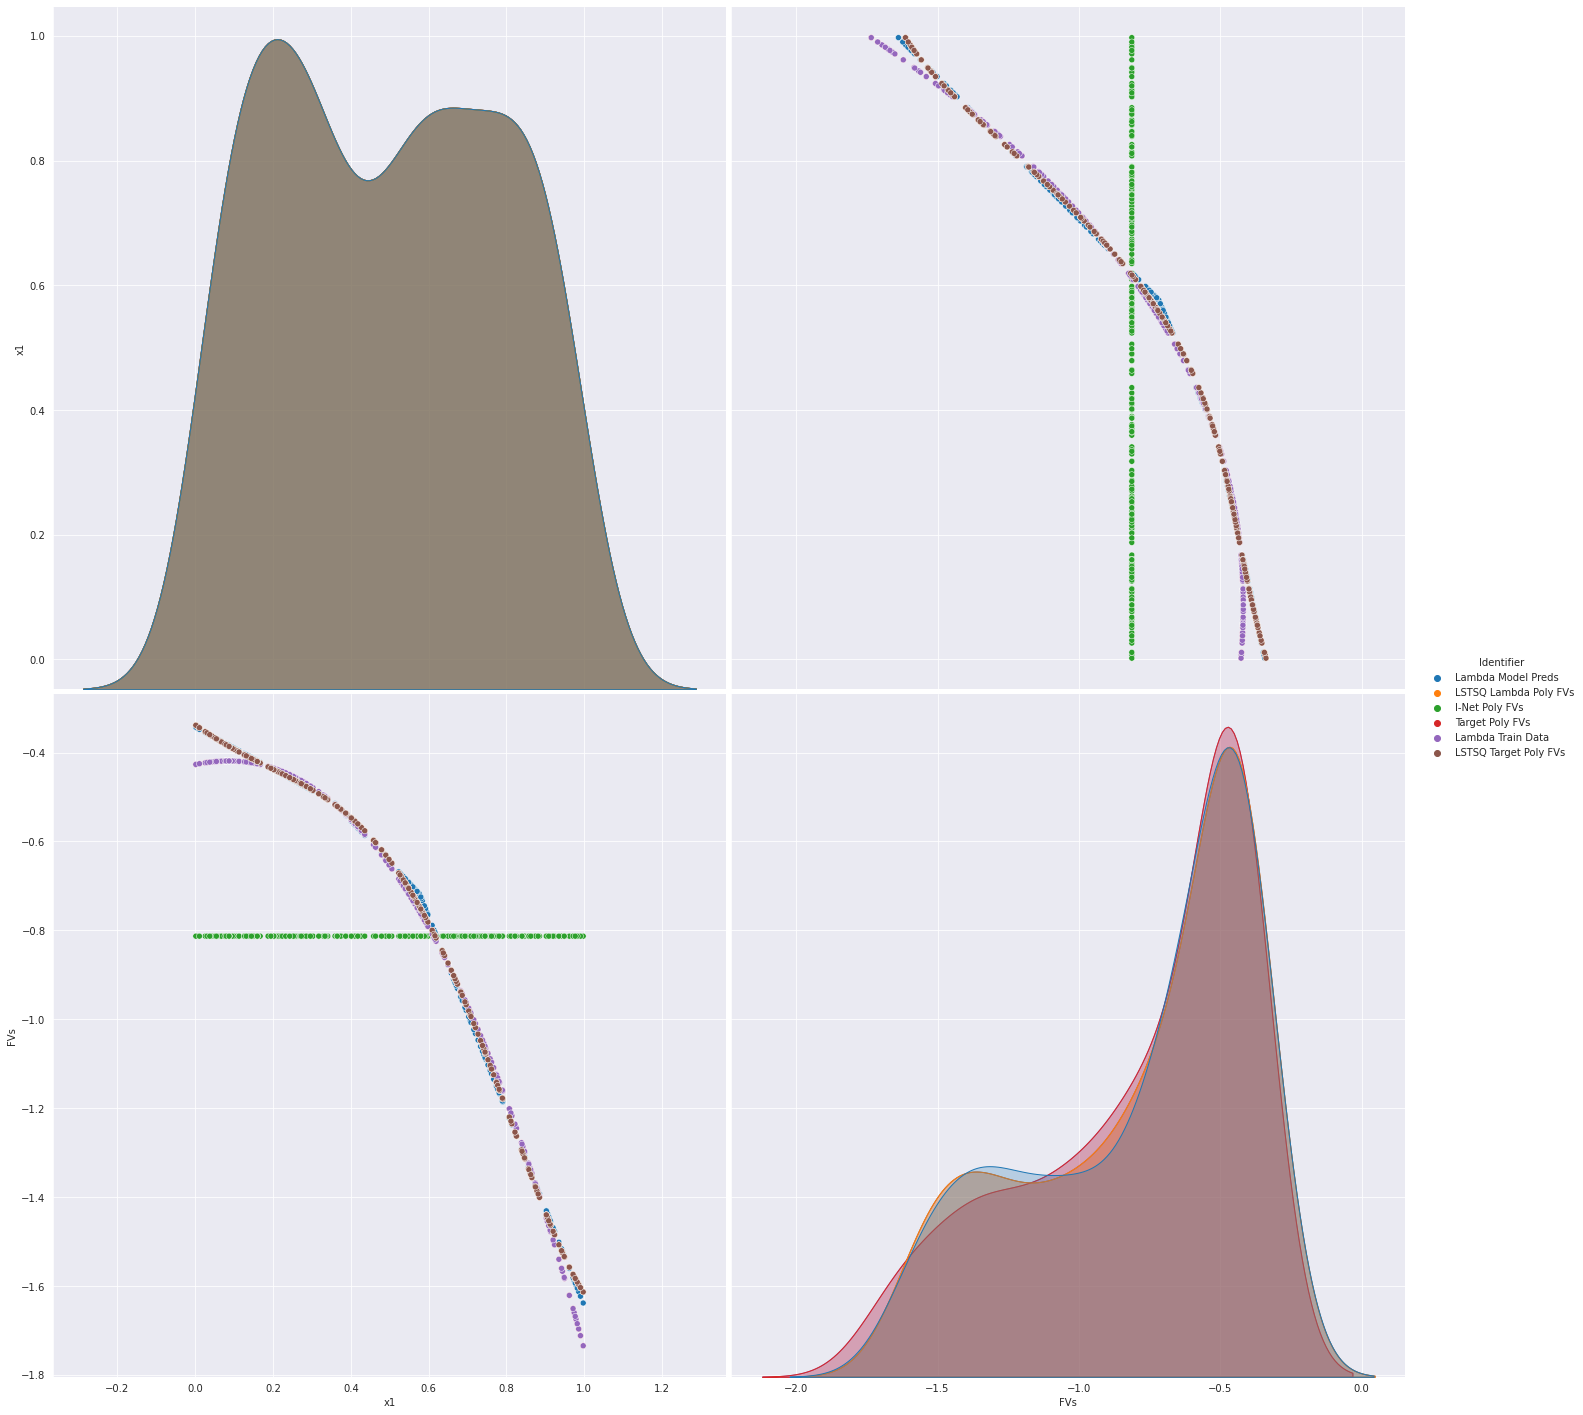

+---------------------------+-----------------------+-----------------------+--------+----------------------------------------------------+
|         Comparison        |          MAE          |        R2-Score       | Poly 1 |                       Poly 2                       |
+---------------------------+-----------------------+-----------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.0064961002659723955 |   0.9994484923276273  |   -    |  -0.614*a**1.0 + 0.5883*a**2.0 + 0.9994*a**3.0 -   |
|            vs.            |                       |                       |        |       6.3879*a**4.0 + 4.134*a**5.0 - 0.3373        |
|  LSTSQ Lambda Preds Poly  |                       |                       |        |                                                    |
|                           |                       |                       |        |                                                    |
|       Lambda Preds

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

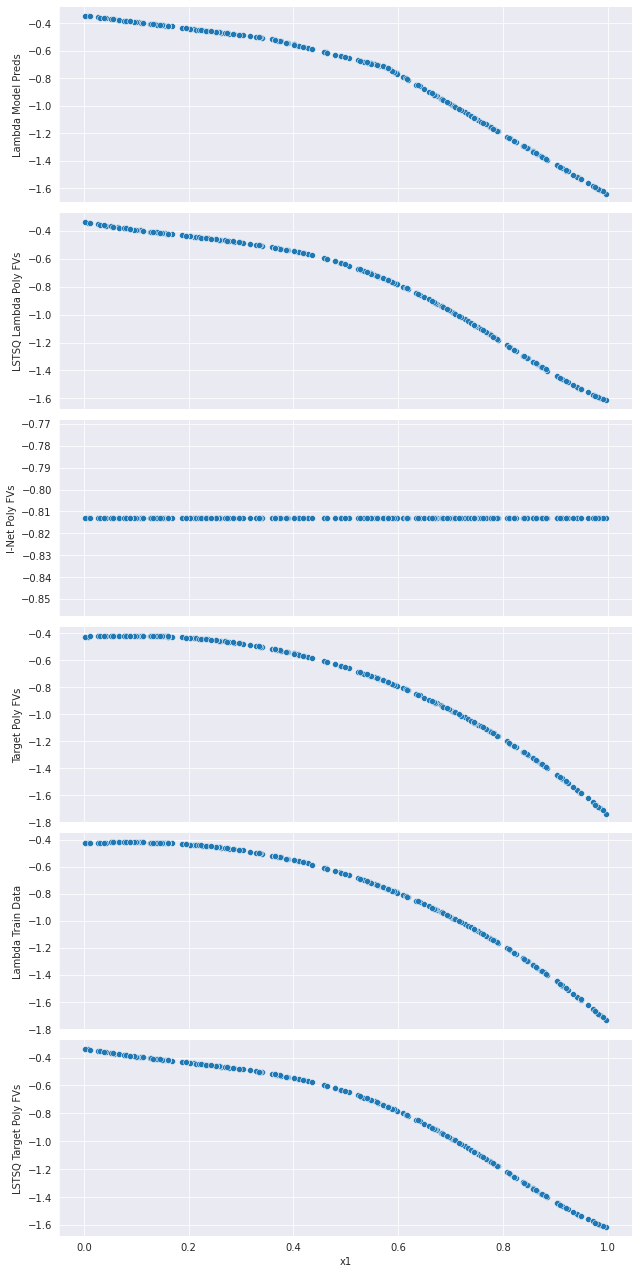

+---------------------------+-----------------------+-----------------------+--------+----------------------------------------------------+
|         Comparison        |          MAE          |        R2-Score       | Poly 1 |                       Poly 2                       |
+---------------------------+-----------------------+-----------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.0064961002659723955 |   0.9994484923276273  |   -    |  -0.614*a**1.0 + 0.5883*a**2.0 + 0.9994*a**3.0 -   |
|            vs.            |                       |                       |        |       6.3879*a**4.0 + 4.134*a**5.0 - 0.3373        |
|  LSTSQ Lambda Preds Poly  |                       |                       |        |                                                    |
|                           |                       |                       |        |                                                    |
|       Lambda Preds

In [49]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [50]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [51]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

In [52]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0371


In [53]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 6.7263


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [54]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [55]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.6982


In [56]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [57]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()